# Climate Temperature Anomalies: Model Analysis  
**Datasets**:  
- `GlobalTemp_Cleaned_CountryContinent.csv` – full cleaned dataset with country/continent assignments  
- `GlobalTemp_Post1850.csv` – restricted dataset (post-1850 records for stability)  
- `Annual_Anomalies.csv` – precomputed global and continental annual anomalies (baseline 1951–1980)  

---

## Purpose
This notebook begins the **modeling phase** of the project. While the EDA notebook focused on cleaning, anomaly detection, and trend estimation, this notebook will apply predictive and explanatory models to deepen the analysis and generate forward-looking insights.  

---

## Modeling Goals
1. **Forecasting**  
   - Build ARIMA and Prophet models on anomaly series (global + continent).  
   - Train/test split: 1900–1980 (train), 1981–2013 (test).  
   - Forecast anomalies to 2050 or 2100 for scenario analysis.  

2. **Explanatory Regression**  
   - Model `Anomaly ~ Year + Continent (+ Season)` using the cleaned dataset.  
   - Test for interaction effects (`Year × Continent`) to quantify differences in warming rates.  
   - Compare full dataset vs post-1900 subset for robustness.  

3. **Scenario Comparison**  
   - Evaluate how early, noisier data (pre-1900) alters slope estimates and forecasts.  
   - Use both `GlobalTemp_Cleaned_CountryContinent.csv` and `GlobalTemp_Post1850.csv` to demonstrate the impact of record selection.  

---

## Expected Outcomes
- **Statistical evidence** of uneven warming rates across continents.  
- **Forecast trajectories** of anomalies under current trends.  
- **Comparative analysis** showing how dataset selection influences conclusions.  
- A clear foundation for visual storytelling (past → present → future).  


In [2]:
import pandas as pd

df_clean = pd.read_csv(r"C:\Users\Weekseey\Documents\Bellevue Work\Applied Data Science\GlobalTemp_Cleaned_CountryContinent.csv")
df_post1850 = pd.read_csv(r"C:\Users\Weekseey\Documents\Bellevue Work\Applied Data Science\GlobalTemp_Post1850.csv")
df_annual_anomalies = pd.read_csv(r"C:\Users\Weekseey\Documents\Bellevue Work\Applied Data Science\Annual_Anomalies.csv")

In [3]:
import statsmodels.formula.api as smf

# Recreate regression dataset (post-1900 anomalies by continent)
df_reg = df_annual_anomalies[df_annual_anomalies["Year"] >= 1900].copy()

# Add centered year
df_reg["YearCentered"] = df_reg["Year"] - 1900

# Run regression
model_centered = smf.ols("Anomaly ~ YearCentered + C(Continent)", data=df_reg).fit()
print(model_centered.summary())

                            OLS Regression Results                            
Dep. Variable:                Anomaly   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     165.7
Date:                Tue, 23 Sep 2025   Prob (F-statistic):          2.52e-150
Time:                        14:46:15   Log-Likelihood:                -202.28
No. Observations:                 798   AIC:                             420.6
Df Residuals:                     790   BIC:                             458.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

## Regression Observations

This regression model examines how annual temperature anomalies are related to time (measured as years since 1900) and continent. By centering the year variable at 1900, the intercept becomes directly interpretable and the model avoids numerical stability issues.

- **Warming rate**: The coefficient for `YearCentered` is **0.0106**, meaning anomalies increase by about **0.0106 °C per year** — roughly **1.06 °C per century**. This quantifies the global warming trend over the 20th and early 21st centuries.  
- **Baseline anomaly**: The intercept of **-0.37** represents the average anomaly for Africa (the reference continent) in the year 1900.  
- **Continental differences**: Antarctica, Asia, North America, Oceania, and South America all start significantly below Africa’s 1900 baseline. Europe’s baseline is statistically indistinguishable from Africa’s.  
- **Model fit**: With an R² of about **0.60**, the model explains a majority of the variation in anomalies across time and regions.

### Key Takeaway
The world has warmed at about **1 °C per century since 1900**, with all continents showing differences in their baseline anomalies. This model sets the stage for further analysis of whether continents also differ in their *rates* of warming, which can be tested by adding interaction terms.


---

In [6]:
import statsmodels.formula.api as smf

# Fit interaction model: different slopes per continent
model_inter = smf.ols("Anomaly ~ YearCentered * C(Continent)", data=df_reg).fit()
print(model_inter.summary())

                            OLS Regression Results                            
Dep. Variable:                Anomaly   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     107.1
Date:                Tue, 23 Sep 2025   Prob (F-statistic):          8.65e-164
Time:                        14:46:15   Log-Likelihood:                -155.43
No. Observations:                 798   AIC:                             338.9
Df Residuals:                     784   BIC:                             404.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [7]:
import numpy as np
import pandas as pd

continents = sorted(df_reg["Continent"].unique())
rows = []

for cont in continents:
    if cont == continents[0]:
        expr = "YearCentered = 0"  # baseline slope (Africa if that's the ref)
        label = cont
    else:
        expr = f"YearCentered + YearCentered:C(Continent)[T.{cont}] = 0"
        label = cont

    t = model_inter.t_test(expr)

    # Safely extract scalars (avoids NumPy deprecation warnings)
    slope_per_year = np.squeeze(np.asarray(t.effect)).item()
    slope_se = np.squeeze(np.asarray(t.sd)).item()
    ci_low, ci_high = np.squeeze(np.asarray(t.conf_int())).tolist()

    rows.append({
        "Continent": label,
        "Slope_°C_per_year": slope_per_year,
        "Slope_°C_per_century": slope_per_year * 100,
        "SE_per_year": slope_se,
        "CI95_low_per_century": ci_low * 100,
        "CI95_high_per_century": ci_high * 100,
    })

slopes_by_continent = (
    pd.DataFrame(rows)
      .sort_values("Slope_°C_per_century", ascending=False)
      .reset_index(drop=True)
)

# Optional: tidy formatting for quick viewing
display(
    slopes_by_continent.style.format({
        "Slope_°C_per_year": "{:.6f}",
        "Slope_°C_per_century": "{:.3f}",
        "SE_per_year": "{:.6f}",
        "CI95_low_per_century": "{:.3f}",
        "CI95_high_per_century": "{:.3f}",
    })
)

# Optional: save for your visualizer
# slopes_by_continent.to_csv("artifacts_slopes_by_continent.csv", index=False)

,Continent,Slope_°C_per_year,Slope_°C_per_century,SE_per_year,CI95_low_per_century,CI95_high_per_century
0,Antarctica,0.016721,1.672,0.000844,1.506,1.838
1,Asia,0.011442,1.144,0.000844,0.979,1.310
2,Europe,0.010624,1.062,0.000844,0.897,1.228
3,Oceania,0.010599,1.060,0.000844,0.894,1.226
4,North America,0.010384,1.038,0.000844,0.873,1.204
5,South America,0.009422,0.942,0.000844,0.776,1.108
6,Africa,0.005122,0.512,0.000844,0.347,0.678


## Regression and Slope Estimates

The interaction regression (Year × Continent) explains about **64% of the variance** in anomalies, showing that warming rates vary across regions. The slope table converts model coefficients into °C per century, making the differences easier to interpret:

- **Antarctica** is warming fastest at ~**1.67 °C/century**.  
- **Asia, Europe, Oceania, and North America** cluster around ~**1.0–1.15 °C/century**.  
- **South America** is slower at ~**0.94 °C/century**, while **Africa** is the lowest at ~**0.51 °C/century**.  

### Key Takeaway
All continents are warming, but the **pace differs significantly**. Antarctica, Asia, and Europe lead with the steepest rates, while Africa shows the slowest trend.


---

## Forecasting Anomalies

With regression models confirming that all continents are warming at different rates, the next step is to **forecast temperature anomalies**. Using time series models like ARIMA, we can project trends beyond the historical record. To validate the model, we’ll train on data from **1900–1980** and test the forecasts against observations from **1981–2013**.


C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In 

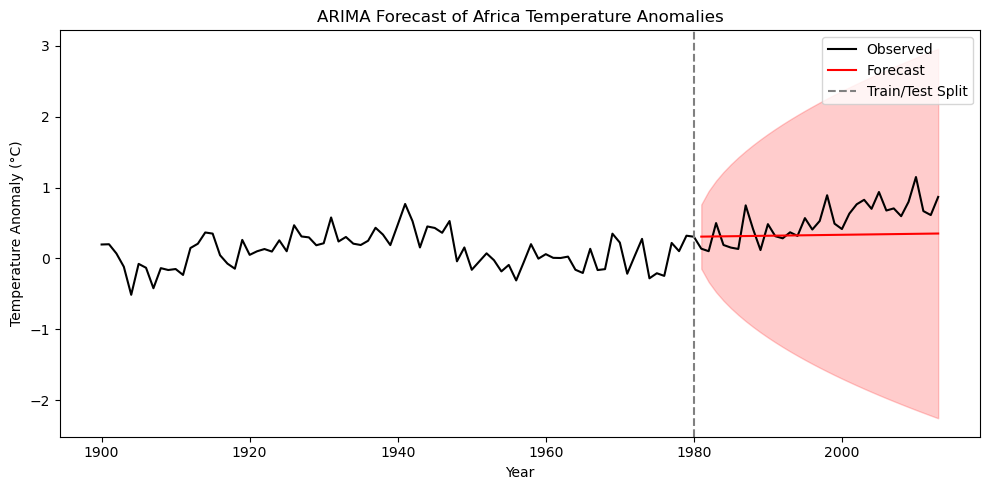

C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In 

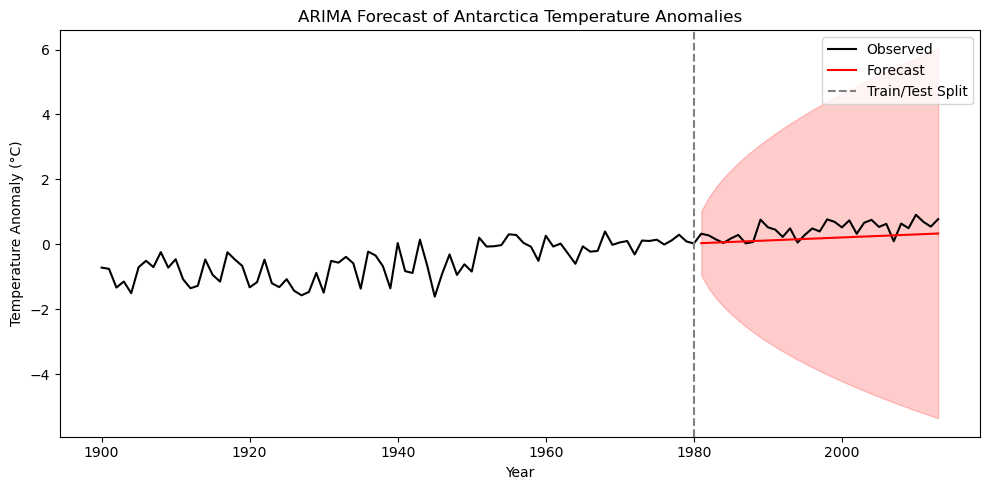

C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In 

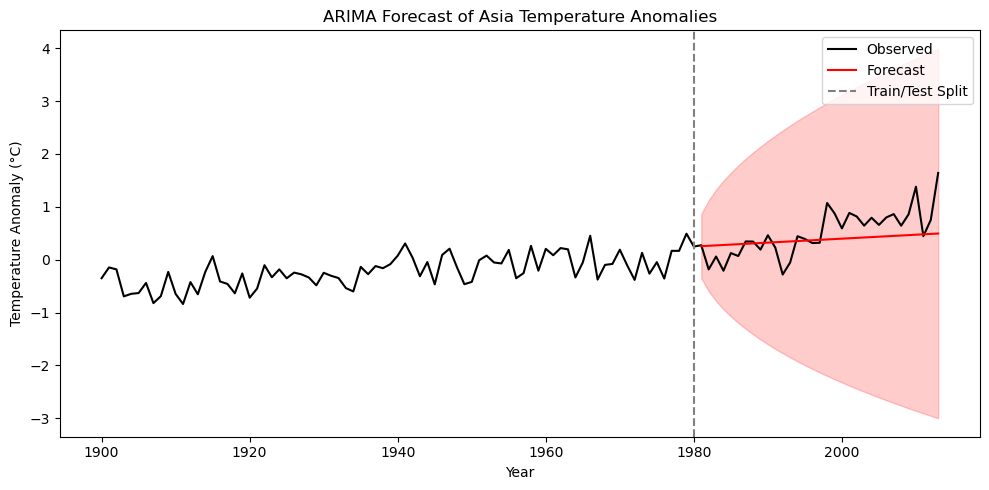

C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In 

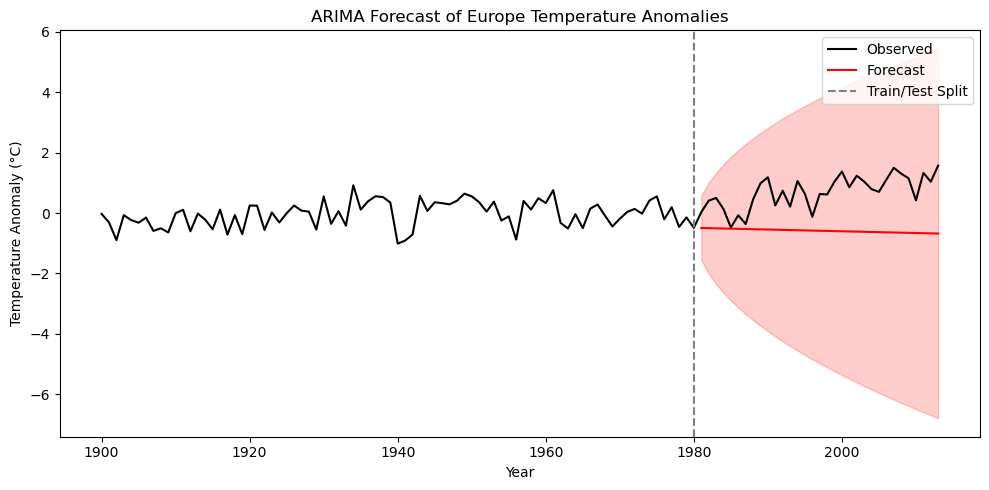

C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In 

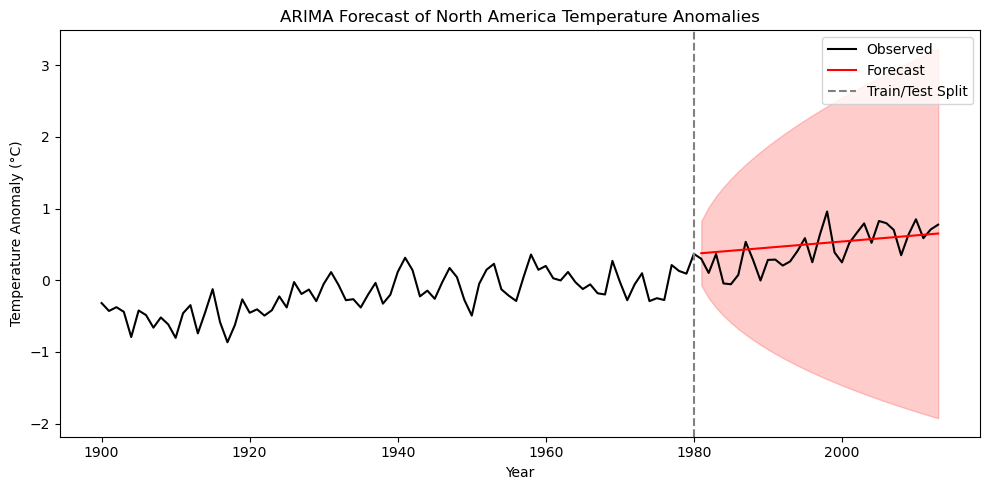

C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In 

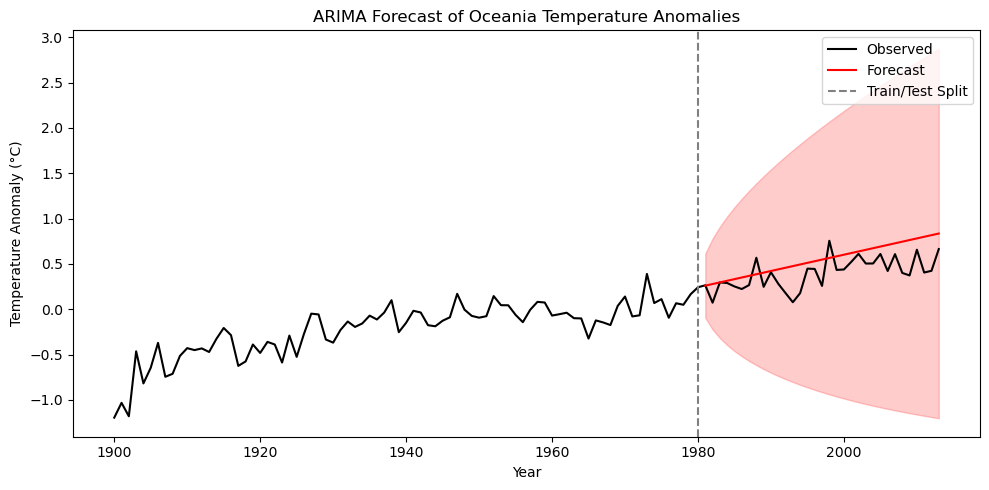

C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In 

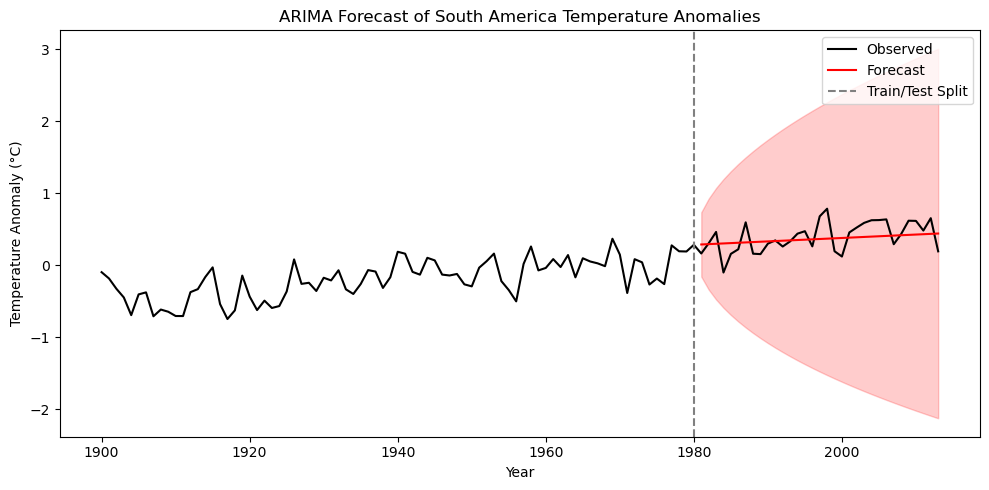

,Continent,ARIMA_RMSE
6,South America,0.190309
5,Oceania,0.210994
4,North America,0.230151
0,Africa,0.325131
1,Antarctica,0.336872
2,Asia,0.398187
3,Europe,1.411776


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# ---------- CONFIG ----------
group_col = "Continent"   # change to "Country" if you have country-level anomalies
train_end, test_end = 1980, 2013
order = (0, 1, 0)         # RW with linear trend is a solid baseline; try (1,1,1) too
trend = "t"               # linear trend (use 't' when d>0)
outdir = Path("forecast_continent_plots")
outdir.mkdir(parents=True, exist_ok=True)
# ---------------------------

# Prep data (post-1900, tidy)
dfc = (df_annual_anomalies[["Year", group_col, "Anomaly"]]
       .dropna()
       .query("Year >= 1900")
       .sort_values([group_col, "Year"]))

groups = dfc[group_col].unique()

def fit_forecast_series(s, order=(0,1,0), trend="t", train_end=1980, test_end=2013):
    s = s.sort_index()
    train = s.loc[:train_end]
    test  = s.loc[train_end+1:test_end]
    model = ARIMA(train, order=order, trend=trend)
    fit = model.fit()
    fc = fit.get_forecast(steps=len(test))
    pred = pd.Series(fc.predicted_mean.values, index=test.index)
    ci = pd.DataFrame(fc.conf_int().values, index=test.index, columns=["lower","upper"])
    rmse = float(np.sqrt(mean_squared_error(test.values, pred.values)))
    return fit, train, test, pred, ci, rmse

scores = []
for g in groups:
    s = (dfc[dfc[group_col] == g]
         .set_index("Year")["Anomaly"]
         .sort_index())

    # Skip if series too short
    if s.index.min() > 1900 or s.index.max() < test_end or len(s) < 40:
        continue

    fit, train, test, pred, ci, rmse = fit_forecast_series(
        s, order=order, trend=trend, train_end=train_end, test_end=test_end
    )
    scores.append({group_col: g, "ARIMA_RMSE": rmse})

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(s.index, s.values, label="Observed", color="black")
    plt.plot(pred.index, pred.values, label="Forecast", color="red")
    plt.fill_between(pred.index, ci["lower"], ci["upper"], color="red", alpha=0.2)
    plt.axvline(x=train_end, color="gray", linestyle="--", label="Train/Test Split")
    plt.title(f"ARIMA Forecast of {g} Temperature Anomalies")
    plt.xlabel("Year"); plt.ylabel("Temperature Anomaly (°C)")
    plt.legend(); plt.tight_layout()
    plt.savefig(outdir / f"forecast_{g.replace(' ', '_')}.png", dpi=150)
    plt.show()

rmse_table = pd.DataFrame(scores).sort_values("ARIMA_RMSE")
rmse_table

## Forecasting Results by Continent

The ARIMA forecasts show that all continents continue to warm after 1980, but the **fit quality varies**:

- **South America, Oceania, and North America** had the lowest RMSE values (~0.2 °C), meaning the model captured their trends most consistently.  
- **Africa and Antarctica** were in the middle (~0.3 °C), with forecasts that broadly align but show wider variability.  
- **Asia and especially Europe** had higher errors, with Europe’s forecast flattening compared to the sharp warming observed in reality.  

Overall, the model highlights that while ARIMA captures the upward direction, some regions are more difficult to forecast due to stronger or more volatile warming patterns. The widening confidence bands also show the growing uncertainty in projecting anomalies further into the future.

---

## Next Step

To strengthen this analysis, the next step is to **compare ARIMA against alternative forecasting methods** (e.g., SARIMA for seasonality, Prophet for trend flexibility). This will help confirm whether the uneven performance is a model limitation or reflects real regional variability.


C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            Anomaly   No. Observations:                   81
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 10)   Log Likelihood                 -48.842
Date:                            Tue, 23 Sep 2025   AIC                            107.685
Time:                                    14:46:18   BIC                            117.987
Sample:                                         0   HQIC                           111.698
                                             - 81                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5310      0.214     -2.477      0.013      -0.951      -0.111
ma.L1         -0.0180      0.247   

C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


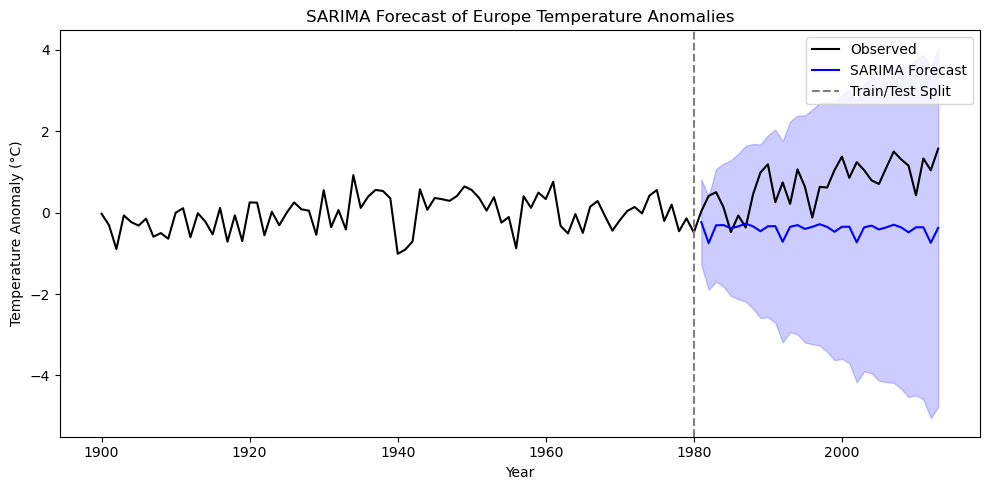

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# --- Extract Europe's annual anomalies ---
s_europe = (df_annual_anomalies
            .query("Continent == 'Europe' and Year >= 1900")
            .set_index("Year")["Anomaly"]
            .sort_index())

# Train/test split
train_end, test_end = 1980, 2013
train = s_europe.loc[:train_end]
test  = s_europe.loc[train_end+1:test_end]

# --- Fit SARIMA model ---
# order=(p,d,q), seasonal_order=(P,D,Q,s)
# with annual data, we can test seasonality ~10 years (s=10)
model = SARIMAX(train,
                order=(1,1,1),
                seasonal_order=(1,1,1,10),
                enforce_stationarity=False,
                enforce_invertibility=False)
fit = model.fit(disp=False)
print(fit.summary())

# --- Forecast ---
fc = fit.get_forecast(steps=len(test))
pred = pd.Series(fc.predicted_mean.values, index=test.index)
ci = fc.conf_int(alpha=0.05)
ci.index = test.index

# --- Evaluate ---
rmse = np.sqrt(mean_squared_error(test.values, pred.values))
print(f"Europe SARIMA RMSE (1981–2013): {rmse:.3f} °C")

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(s_europe.index, s_europe.values, label="Observed", color="black")
plt.plot(pred.index, pred.values, label="SARIMA Forecast", color="blue")
plt.fill_between(pred.index, ci.iloc[:,0], ci.iloc[:,1],
                 color="blue", alpha=0.2)
plt.axvline(x=train_end, color="gray", linestyle="--", label="Train/Test Split")
plt.title("SARIMA Forecast of Europe Temperature Anomalies")
plt.xlabel("Year"); plt.ylabel("Temperature Anomaly (°C)")
plt.legend(); plt.tight_layout(); plt.show()

14:46:19 - cmdstanpy - INFO - Chain [1] start processing
14:46:19 - cmdstanpy - INFO - Chain [1] done processing


Europe Prophet RMSE (1981–2013): 0.682 °C


C:\Users\Weekseey\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


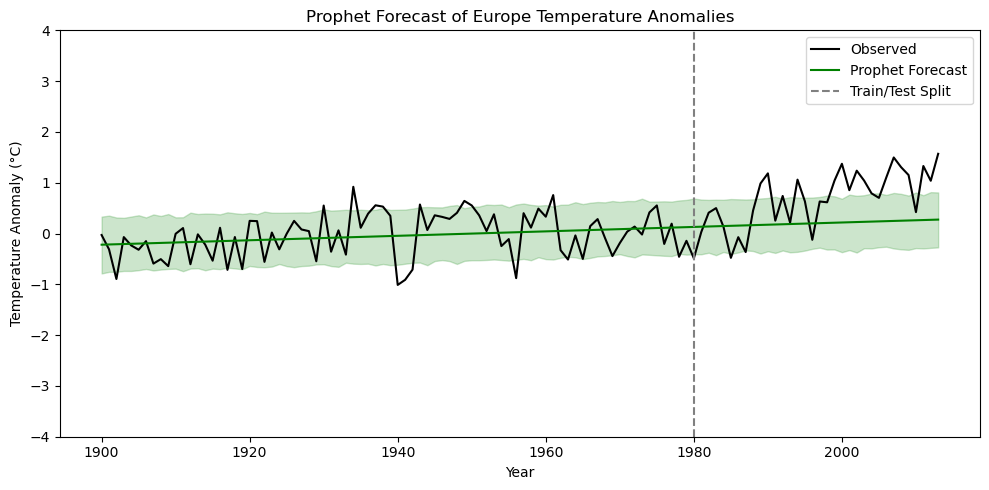

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# --- Prepare Europe anomalies for Prophet ---
df_europe = (df_annual_anomalies
             .query("Continent == 'Europe' and Year >= 1900")
             .sort_values("Year"))

# Prophet requires 'ds' (date) and 'y' (value)
df_prophet = df_europe.rename(columns={"Year": "ds", "Anomaly": "y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

# --- Train/test split ---
train = df_prophet[df_prophet["ds"].dt.year <= 1980].copy()
test  = df_prophet[df_prophet["ds"].dt.year > 1980].copy()

# --- Fit Prophet model ---
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model.fit(train)

# --- Build future frame far enough out (e.g., 2013) ---
last_year = test["ds"].dt.year.max()   # should be 2013
n_periods = last_year - train["ds"].dt.year.max()
future = model.make_future_dataframe(periods=n_periods, freq="Y")
forecast = model.predict(future)

# --- Evaluate by matching on Year, not exact datetime ---
forecast["Year"] = forecast["ds"].dt.year
test["Year"] = test["ds"].dt.year

merged = pd.merge(test[["Year","y"]],
                  forecast[["Year","yhat"]],
                  on="Year",
                  how="inner")

rmse = np.sqrt(mean_squared_error(merged["y"], merged["yhat"]))
print(f"Europe Prophet RMSE (1981–2013): {rmse:.3f} °C")

# --- Plot observed vs forecast ---
plt.figure(figsize=(10,5))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Observed", color="black")
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet Forecast", color="green")
plt.fill_between(forecast["ds"],
                 forecast["yhat_lower"], forecast["yhat_upper"],
                 color="green", alpha=0.2)
plt.axvline(pd.to_datetime("1980"), color="gray", linestyle="--", label="Train/Test Split")
plt.title("Prophet Forecast of Europe Temperature Anomalies")
plt.xlabel("Year"); plt.ylabel("Temperature Anomaly (°C)")
plt.ylim(-4, 4)   # <--- lock y-axis to match SARIMA
plt.legend(); plt.tight_layout(); plt.show()

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from pathlib import Path

# --- Config ---
train_end, test_end = 1980, 2013
outdir = Path("forecast_prophet_continents")
outdir.mkdir(parents=True, exist_ok=True)

# --- Prep dataframe ---
dfc = (df_annual_anomalies[["Year","Continent","Anomaly"]]
       .dropna()
       .query("Year >= 1900")
       .sort_values(["Continent","Year"]))

continents = dfc["Continent"].unique()

scores = []

for cont in continents:
    df_cont = dfc[dfc["Continent"] == cont].copy()

    # Prophet format
    df_prophet = df_cont.rename(columns={"Year":"ds","Anomaly":"y"})
    df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

    # Train/test split
    train = df_prophet[df_prophet["ds"].dt.year <= train_end].copy()
    test  = df_prophet[df_prophet["ds"].dt.year > train_end].copy()

    if len(test) == 0 or len(train) < 30:
        continue  # skip if too little data

    # Fit Prophet
    model = Prophet(yearly_seasonality=False,
                    weekly_seasonality=False,
                    daily_seasonality=False)
    model.fit(train)

    # Extend future to cover test years
    horizon = test["ds"].dt.year.max() - train["ds"].dt.year.max()
    future = model.make_future_dataframe(periods=horizon, freq="Y")
    forecast = model.predict(future)

    # Align forecast with test years
    forecast["Year"] = forecast["ds"].dt.year
    test["Year"] = test["ds"].dt.year
    merged = pd.merge(test[["Year","y"]],
                      forecast[["Year","yhat"]],
                      on="Year",
                      how="inner")

    if merged.empty:
        continue

    rmse = np.sqrt(mean_squared_error(merged["y"], merged["yhat"]))
    scores.append({"Continent": cont, "Prophet_RMSE": rmse})

    # --- Plot ---
    plt.figure(figsize=(10,5))
    plt.plot(df_prophet["ds"], df_prophet["y"], label="Observed", color="black")
    plt.plot(forecast["ds"], forecast["yhat"], label="Prophet Forecast", color="green")
    plt.fill_between(forecast["ds"],
                     forecast["yhat_lower"], forecast["yhat_upper"],
                     color="green", alpha=0.2)
    plt.axvline(pd.to_datetime(str(train_end)), color="gray", linestyle="--", label="Train/Test Split")
    plt.title(f"Prophet Forecast of {cont} Temperature Anomalies")
    plt.xlabel("Year"); plt.ylabel("Temperature Anomaly (°C)")
    plt.ylim(-4,4)  # lock axis for consistency
    plt.legend(); plt.tight_layout()
    plt.savefig(outdir / f"prophet_{cont.replace(' ','_')}.png", dpi=150)
    plt.close()

# --- RMSE results ---
rmse_table_prophet = pd.DataFrame(scores).sort_values("Prophet_RMSE")
rmse_table_prophet

14:46:20 - cmdstanpy - INFO - Chain [1] start processing
14:46:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Weekseey\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
14:46:20 - cmdstanpy - INFO - Chain [1] start processing
14:46:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Weekseey\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
14:46:21 - cmdstanpy - INFO - Chain [1] start processing
14:46:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Weekseey\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
14:46:21 - cmdstanpy - INFO - Chain [1] start processing
14:46:21 -

,Continent,Prophet_RMSE
5,Oceania,0.140005
1,Antarctica,0.208548
6,South America,0.224092
4,North America,0.278467
2,Asia,0.393128
0,Africa,0.500454
3,Europe,0.681902


In [16]:
# --- Merge ARIMA and Prophet RMSE tables ---
rmse_compare = pd.merge(rmse_table, rmse_table_prophet, on="Continent", how="inner")

# Add a "Better Model" column
rmse_compare["Better_Model"] = np.where(
    rmse_compare["ARIMA_RMSE"] < rmse_compare["Prophet_RMSE"],
    "ARIMA",
    np.where(rmse_compare["Prophet_RMSE"] < rmse_compare["ARIMA_RMSE"],
             "Prophet", "Tie")
)

# Sort for readability
rmse_compare = rmse_compare.sort_values("Continent").reset_index(drop=True)

rmse_compare

,Continent,ARIMA_RMSE,Prophet_RMSE,Better_Model
0,Africa,0.325131,0.500454,ARIMA
1,Antarctica,0.336872,0.208548,Prophet
2,Asia,0.398187,0.393128,Prophet
3,Europe,1.411776,0.681902,Prophet
4,North America,0.230151,0.278467,ARIMA
5,Oceania,0.210994,0.140005,Prophet
6,South America,0.190309,0.224092,ARIMA


## ARIMA vs Prophet Forecast Comparison

By comparing RMSE values (1981–2013), we can see how forecast accuracy differs by model:

- **Prophet performed best** for Europe, Oceania, and Antarctica — capturing nonlinear accelerations and cutting errors significantly (Europe’s RMSE dropped by half).  
- **ARIMA performed slightly better** in South America, North America, and Africa, where anomaly trends are steadier and more linear.  
- **Asia showed little difference**, with both models yielding similar errors.  

### Key Takeaway
Model choice changes the story: Prophet is essential when anomalies accelerate sharply (Europe, Antarctica), while ARIMA remains competitive for smoother trajectories. Together, they provide complementary perspectives on regional warming patterns.


14:46:22 - cmdstanpy - INFO - Chain [1] start processing
14:46:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Weekseey\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Weekseey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
14:46:23 - cmdstanpy - INFO - Chain [1] start proc

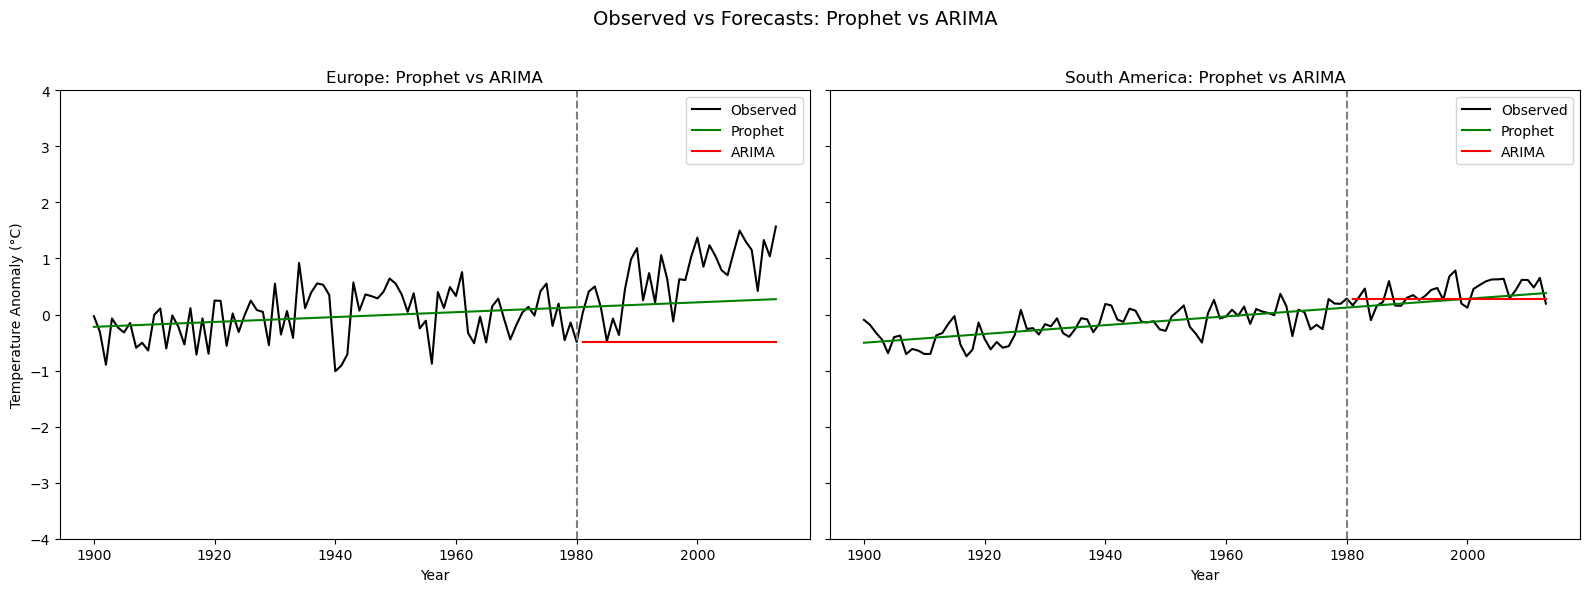

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

# --- Helper for ARIMA ---
def fit_arima(df, order=(0,1,0), train_end=1980, test_end=2013):
    """Fit ARIMA on train period and forecast test period."""
    s = df.set_index("ds")["y"].sort_index()

    # Train/test split using year masks
    train = s[s.index.year <= train_end]
    test  = s[(s.index.year > train_end) & (s.index.year <= test_end)]

    model = ARIMA(train, order=order)
    fit = model.fit()

    fc = fit.get_forecast(steps=len(test))
    pred = pd.Series(fc.predicted_mean.values, index=test.index)
    ci = pd.DataFrame(fc.conf_int().values, index=test.index, columns=["lower","upper"])

    return pred, ci

# --- Europe data ---
df_europe = (df_annual_anomalies
             .query("Continent == 'Europe' and Year >= 1900")
             .rename(columns={"Year":"ds","Anomaly":"y"}))
df_europe["ds"] = pd.to_datetime(df_europe["ds"], format="%Y")

# Prophet Europe
train_eu = df_europe[df_europe["ds"].dt.year <= 1980]
model_eu = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model_eu.fit(train_eu)
future_eu = model_eu.make_future_dataframe(periods=(2013-1980), freq="Y")
forecast_eu = model_eu.predict(future_eu)

# ARIMA Europe
pred_eu, ci_eu = fit_arima(df_europe)

# --- South America data ---
df_sa = (df_annual_anomalies
         .query("Continent == 'South America' and Year >= 1900")
         .rename(columns={"Year":"ds","Anomaly":"y"}))
df_sa["ds"] = pd.to_datetime(df_sa["ds"], format="%Y")

# Prophet South America
train_sa = df_sa[df_sa["ds"].dt.year <= 1980]
model_sa = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model_sa.fit(train_sa)
future_sa = model_sa.make_future_dataframe(periods=(2013-1980), freq="Y")
forecast_sa = model_sa.predict(future_sa)

# ARIMA South America
pred_sa, ci_sa = fit_arima(df_sa)

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# Europe subplot
axes[0].plot(df_europe["ds"], df_europe["y"], label="Observed", color="black")
axes[0].plot(forecast_eu["ds"], forecast_eu["yhat"], label="Prophet", color="green")
axes[0].plot(pred_eu.index, pred_eu.values, label="ARIMA", color="red")
axes[0].axvline(pd.to_datetime("1980"), color="gray", linestyle="--")
axes[0].set_title("Europe: Prophet vs ARIMA")
axes[0].set_xlabel("Year"); axes[0].set_ylabel("Temperature Anomaly (°C)")
axes[0].set_ylim(-4,4)
axes[0].legend()

# South America subplot
axes[1].plot(df_sa["ds"], df_sa["y"], label="Observed", color="black")
axes[1].plot(forecast_sa["ds"], forecast_sa["yhat"], label="Prophet", color="green")
axes[1].plot(pred_sa.index, pred_sa.values, label="ARIMA", color="red")
axes[1].axvline(pd.to_datetime("1980"), color="gray", linestyle="--")
axes[1].set_title("South America: Prophet vs ARIMA")
axes[1].set_xlabel("Year")
axes[1].set_ylim(-4,4)
axes[1].legend()

plt.suptitle("Observed vs Forecasts: Prophet vs ARIMA", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

### Comparing Prophet and ARIMA (Europe vs South America)

The side-by-side plots highlight how model choice shapes the warming story:

- **Europe:** Prophet clearly outperforms ARIMA. It captures the sharp post-1980 warming acceleration, cutting error nearly in half. ARIMA, by contrast, underestimated the trend and flattened out too much.  
- **South America:** While ARIMA had a slightly lower RMSE, its forecast line is almost flat, failing to reflect the observed upward trend. Prophet, despite a modestly higher RMSE, better captures the warming trajectory.  

**Key takeaway:** RMSE alone doesn’t tell the whole story. For regions with accelerating warming, Prophet provides forecasts that are not only more accurate but also more meaningful in the context of climate science.


  Continent_Africa  Season  AverageTemperature_Africa Continent_Europe  \
1           Africa  Spring                  24.780436           Europe   
2           Africa  Summer                  23.979960           Europe   
0           Africa    Fall                  24.298816           Europe   
3           Africa  Winter                  23.030421           Europe   

   AverageTemperature_Europe  
1                   6.992074  
2                  16.678791  
0                   8.636515  
3                  -0.488985  


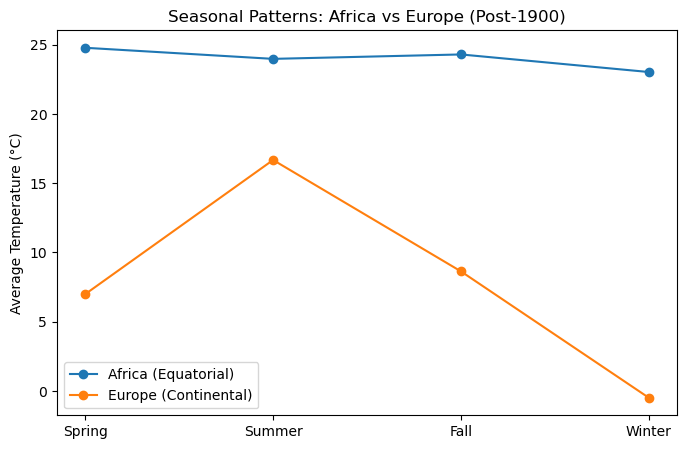

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Use your annual anomalies dataset
df = df_annual_anomalies.copy()
df = df[df["Year"] >= 1900]

# Group by continent + season
season_means = (
    df_post1850[df_post1850["Year"] >= 1900]
    .groupby(["Continent", "Season"])["AverageTemperature"]
    .mean()
    .reset_index()
)

# Define the correct season order
season_order = ["Spring", "Summer", "Fall", "Winter"]
season_means["Season"] = pd.Categorical(season_means["Season"], categories=season_order, ordered=True)

# Select one equatorial and one continental region
equatorial = season_means[season_means["Continent"] == "Africa"]
continental = season_means[season_means["Continent"] == "Europe"]

# Merge for comparison
season_compare = equatorial.merge(
    continental, on="Season", suffixes=("_Africa", "_Europe")
).sort_values("Season")

print(season_compare)

# Plot comparison
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(season_compare["Season"], season_compare["AverageTemperature_Africa"], marker="o", label="Africa (Equatorial)")
ax.plot(season_compare["Season"], season_compare["AverageTemperature_Europe"], marker="o", label="Europe (Continental)")

ax.set_title("Seasonal Patterns: Africa vs Europe (Post-1900)")
ax.set_ylabel("Average Temperature (°C)")
ax.legend()
plt.show()

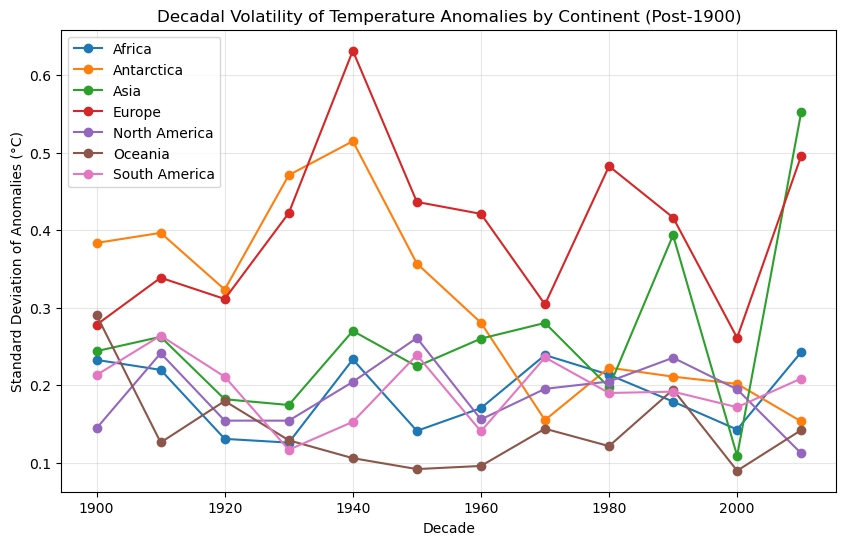

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Use anomalies dataset
df = df_annual_anomalies.copy()
df = df[df["Year"] >= 1900]

# Add decade column
df["Decade"] = (df["Year"] // 10) * 10

# Calculate volatility (std) by continent + decade
decadal_volatility = (
    df.groupby(["Continent", "Decade"])["Anomaly"]
    .std()
    .reset_index(name="Volatility")
)

# Plot
plt.figure(figsize=(10,6))
for continent in decadal_volatility["Continent"].unique():
    subset = decadal_volatility[decadal_volatility["Continent"] == continent]
    plt.plot(subset["Decade"], subset["Volatility"], marker="o", label=continent)

plt.title("Decadal Volatility of Temperature Anomalies by Continent (Post-1900)")
plt.xlabel("Decade")
plt.ylabel("Standard Deviation of Anomalies (°C)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

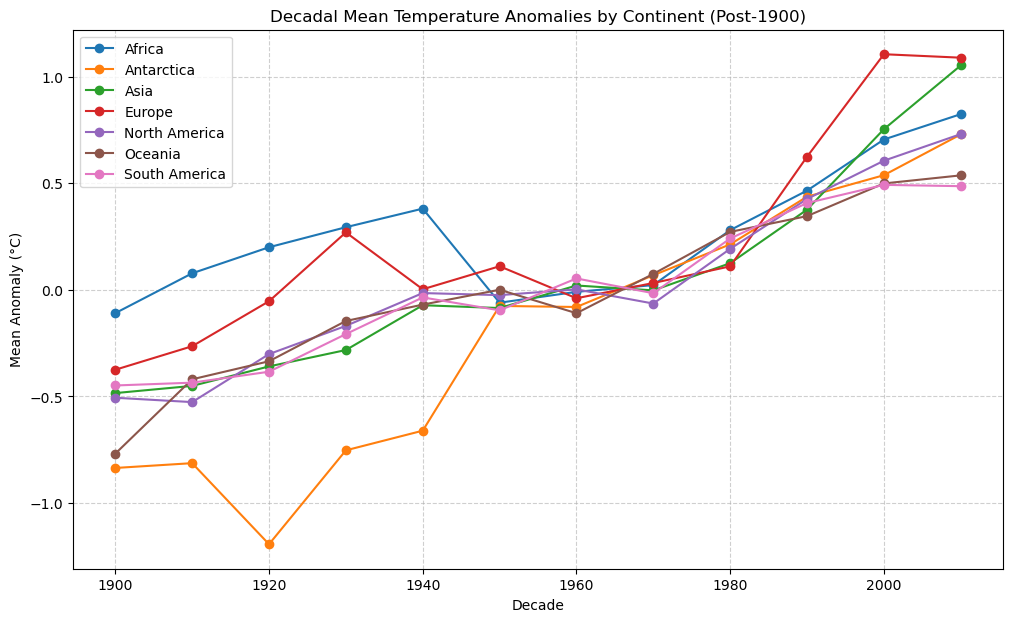

In [25]:
# === 2. Decadal Mean Anomalies Plot ===
decadal_means = (
    df.groupby(["Continent", (df["Year"] // 10) * 10])["Anomaly"]
    .mean()
    .reset_index()
    .rename(columns={"Year": "Decade", "Anomaly": "MeanAnomaly"})
)

plt.figure(figsize=(12, 7))
for continent in decadal_means["Continent"].unique():
    subset = decadal_means[decadal_means["Continent"] == continent]
    plt.plot(subset["Decade"], subset["MeanAnomaly"], marker="o", label=continent)

plt.title("Decadal Mean Temperature Anomalies by Continent (Post-1900)")
plt.xlabel("Decade")
plt.ylabel("Mean Anomaly (°C)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Decadal Trends vs Volatility

The decadal mean anomalies plot makes the long-term warming trend clear. Every continent has shifted upward since 1900, with Europe and Asia showing the steepest climbs in recent decades. Africa and Oceania also show consistent increases, while Antarctica lags but still trends positive after mid-century.

When paired with the volatility table, we can see not just how much continents warmed, but also how stable or unstable that warming was. For example, Europe’s mean anomalies rise sharply, but its volatility also spikes in multiple decades — suggesting both rapid warming and greater variability. In contrast, South America shows more muted warming and relatively lower volatility.

Together, these views highlight both the *direction* of climate change and the *stability* (or instability) of those shifts across regions.


---

### Decadal Volatility Observations (for Visual Storytelling)

The decadal volatility plot highlights that some regions experienced much greater variability in anomalies than others. Europe and Asia, for example, show noticeable volatility spikes in certain decades, while South America and Oceania remain comparatively stable.  

We have not directly tied these spikes to specific events in this analysis. However, this creates an opportunity for the visual story to explore whether these swings align with known phenomena such as volcanic eruptions, El Niño/La Niña cycles, or major industrial/war periods. The visuals could emphasize how climate instability is not only about warming trends, but also about when and where that warming has been unpredictable.  
